In [1]:
import os 
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader

Before Reading notebook, I suggest you to go through the YOLOV2 paper or https://arxiv.org/abs/1612.08242, or watch a quick youtube video on YOLOV2

Let's get started.

## YOLOv2 Configurations
These are different configurations used throughout the notebook, changes here will reflet globaly.

In [2]:
NO_OF_ANCHOR_BOX = N = 5
S = 13  #No of girds in Yolov2
NO_OF_CLASS = C =  4
HEIGHT = H = 416
WIDTH = W = 416
SCALE = 32

DEVICE =device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = batch_size = 8


ANCHOR_BOXES = A = [[ 5.3623,  8.1648],
        [ 2.6154,  3.6588],
        [ 5.8350,  7.8299],
        [ 2.7199,  3.6921],
        [ 9.7198, 10.3616]]  #Calculated using K-means on the African Animals dataset

## Custom Dataset Preperation 
We need a custom dataset to handel the images and thier bounding boxes, pytorch provides some utilities to do that. We will utilize some of them. Also pytorch provides V2 transforms which automaticaly handel both bounding box transformations and image transformation. I would encourage you to go through pytorch v2 transforms once to understand it.

Also if you are unable to understand something I would recommand to go through pytorch docs on that topic once and jump back in thereafter.

### Dataset Utils

In [3]:
def convert_to_corners(boxes):
    """
    Convert bounding boxes from (x_center, y_center, width, height) format to
    (x_min, y_min, x_max, y_max) format.

    Args:
        boxes (Tensor): Tensor of shape (N, 4) containing bounding boxes in the format (x_center, y_center, width, height).

    Returns:
        Tensor: Tensor of shape (N, 4) containing bounding boxes in the format (x_min, y_min, x_max, y_max).
    """
    x_center, y_center, width, height = boxes.unbind(1)
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    x_max = x_center + width / 2
    y_max = y_center + height / 2
    return torch.stack((x_min, y_min, x_max, y_max), dim=1)



def intersection_over_union(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list or tuple
        Format: [center_x, center_y, width, height]
        The (center_x, center_y) position is the center of the bounding box,
        and width and height define its dimensions.
    bb2 : list or tuple
        Format: [center_x, center_y, width, height]
        The (center_x, center_y) position is the center of the bounding box,
        and width and height define its dimensions.

    Returns
    -------
    float
        in [0, 1]
    """
    bb1 = bb1.to('cpu')
    bb2 = bb2.to('cpu')
    bboxes = torch.vstack((bb1, bb2))
    # Convert center-width-height format to top-left and bottom-right format
    bboxes = convert_to_corners(bboxes)
    bb1_x1, bb1_y1, bb1_x2, bb1_y2 = bboxes[0]
    bb2_x1, bb2_y1, bb2_x2, bb2_y2 = bboxes[1]


    # Ensure validity of bounding boxes
    if  bb1_x1 > bb1_x2 or bb1_y1 > bb1_y2 or bb2_x1 > bb2_x2 or bb2_y1 > bb2_y2:
        return 0

    # Determine the coordinates of the intersection rectangle
    x_left = max(bb1_x1, bb2_x1)
    y_top = max(bb1_y1, bb2_y1)
    x_right = min(bb1_x2, bb2_x2)
    y_bottom = min(bb1_y2, bb2_y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # Compute the area of both AABBs
    bb1_area = (bb1_x2 - bb1_x1) * (bb1_y2 - bb1_y1)
    bb2_area = (bb2_x2 - bb2_x1) * (bb2_y2 - bb2_y1)

    # Compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the intersection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

    return iou
           

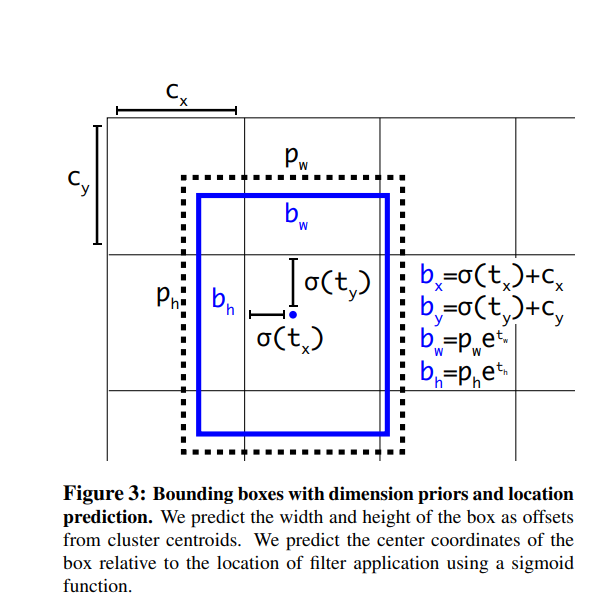

We will utilize this information to build the dataset accordingly

### Custom Dataset

In [3]:
from torch.utils.data import Dataset
from torchvision.transforms import v2
from torchvision.io import read_image
from torchvision import tv_tensors


class AfricanWildlifeDataset(Dataset):
    def __init__(self, rootdir, transform=None):
        """
        Initializes the dataset.

        Parameters:
        - rootdir (str): The root directory containing image folders.
        - transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = rootdir
        self.image_paths = []
        self.transform = transform

        class_names = os.listdir(self.root_dir)
        for directory in class_names:
            files = os.listdir(os.path.join(self.root_dir, directory))
            self.image_paths += [
                os.path.join(directory, file)
                for file in files
                if os.path.splitext(file)[1] == ".jpg"
            ]

    def __len__(self):
        """
        Returns the total number of images.

        Returns:
        - int: Number of images in the dataset.
        """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Fetches the sample and target for the given index.

        Parameters:
        - idx (int): Index of the sample to fetch.

        Returns:
        - tuple: (image, target) where target is the formatted target for YOLOv2.
        """
        sample = self._make_sample(idx)
        img, labels, bboxes = sample["image"], sample["labels"], sample["bbox"]
        _, height, width = img.size()

        target = self._make_target(bboxes, labels, height, width)

        return img, target

    def _make_sample(self, idx):
        """
        Creates a sample formatted as a dictionary.

        Parameters:
        - idx (int): Index of the sample to create.

        Returns:
        - dict: A dictionary with 'image', 'labels', and 'bbox'.
        """
        img_path = os.path.join(self.root_dir, self.image_paths[idx])
        target_path = os.path.splitext(img_path)[0] + ".txt"
        img = read_image(img_path)
        _, height, width = img.size()
        bbox = []
        labels = []

        with open(target_path, "r") as f:
            data = f.readlines()
            for line in data:
                values = line.split()
                labels.append(int(values[0]))
                temp_bbox = [float(val) for val in values[1:]]

                x, y = (
                    temp_bbox[0] * width,
                    temp_bbox[1] * height,
                )  # center of the bounding box
                box_width, box_height = temp_bbox[2] * width, temp_bbox[3] * height
                bbox += [[x, y, box_width, box_height]]

        # Converting the bboxes into pytorch bbox tensor
        bboxes = tv_tensors.BoundingBoxes(
            bbox, format="CXCYWH", canvas_size=img.shape[-2:]
        )

        sample = {"image": img, "labels": torch.tensor(labels), "bbox": bboxes}

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

    def _make_target(self, bboxes, labels, height, width):
        """
        Formats the target in YOLOv2 format.

        Parameters:
        - bboxes (tv_tensors.BoundingBoxes): Bounding boxes of the objects.
        - labels (torch.Tensor): Labels of the objects.
        - height (int): Height of the image.
        - width (int): Width of the image.

        Returns:
        - torch.Tensor: The formatted target tensor.
        """

        target = torch.zeros(S, S, NO_OF_ANCHOR_BOX, 1 + 4 + C)  # S*S*N, 1+4+C

        to_exclude = []
        for bbox, label in zip(bboxes, labels):
            cx, cy = bbox[0] / SCALE, bbox[1] / SCALE  # Float values
            pos = (int(cx), int(cy))
            pos = min(pos[0], 12), min(pos[1], 12)
            bx, by = cx - int(cx), cy - int(cy)
            box_width, box_height = bbox[2] / SCALE, bbox[3] / SCALE

            assigned_anchor_box = self.match_anchor_box(
                box_width, box_height, to_exclude
            )
            anchor_box = ANCHOR_BOXES[assigned_anchor_box]

            bw_by_Pw, bh_by_ph = box_width / anchor_box[0], box_height / anchor_box[1]
            target[pos[0], pos[1], assigned_anchor_box, 0:5] = torch.tensor(
                [1, bx, by, bw_by_Pw, bh_by_ph]
            )
            target[pos[0], pos[1], assigned_anchor_box, 5 + int(label)] = 1

            to_exclude.append(assigned_anchor_box)

        return target
    
    

    def inverse_target(self, ground_truth, S=S, SCALE= SCALE, anchor_boxes= ANCHOR_BOXES):
        """
        Converts the target tensor back to bounding boxes and labels.

        Parameters:
        - ground_truth (torch.Tensor): The ground truth tensor.
        - S (int, optional): The size of the grid. Default is 13.
        - SCALE (int, optional): The scale factor. Default is 32.
        - anchor_boxes (list, optional): List of anchor boxes. Default is None.

        Returns:
        - tuple: (bbox, labels) where bbox are the bounding boxes and labels are the object labels.
        """
        bboxes = []
        labels = []
        ground_truth = ground_truth.to(device)
        
        cx = cy = torch.tensor([i for i in range(13)], device=device)

        #for getting the center point of pred bb, bx = sig(tx)+cx in paper
        ground_truth = ground_truth.permute(0,3,4,2,1)
        ground_truth[...,1:2,:,:] += cx
        ground_truth = ground_truth.permute(0,1,2,4,3)
        ground_truth[...,2:3,:,:] += cy                             
        ground_truth = ground_truth.permute((0,3,4, 1,2))   #bakck to B,13,13,5,9

        ground_truth[..., 1:3]*=32  #to pixels

        #Calculating the height and width in pixels

        # anchor_matrix = torch.empty_like(preds)
        ground_truth[...,3:5]*=torch.tensor(anchor_boxes, device=device)  
        # preds+=anchor_matrix
        ground_truth[..., 3:5] = ground_truth[..., 3:5]*32  # back to pixel values

        bbox = ground_truth[ground_truth[..., 0] ==1][..., 1:5]
        _ , labels = torch.max(ground_truth[ground_truth[..., 0] ==1][..., 5:].view(-1,C), dim = -1)

        return bbox, labels


    def match_anchor_box(self, bbox_w, bbox_h, to_exclude=[], anchor_boxes=ANCHOR_BOXES):
        """
        Matches the bounding box to the closest anchor box.

        Parameters:
        - box_width (float): The width of the bounding box.
        - box_height (float): The height of the bounding box.
        - to_exclude (list): List of anchor boxes to exclude.

        Returns:
        - int: Index of the matched anchor box.
        """
        iou = []
        for i, box in enumerate(anchor_boxes):
            if i in to_exclude:
                iou.append(0)
                continue
            intersection_width = min(box[0], bbox_w)  # Scale up as h, w in range 0-13
            intersection_height = min(box[1], bbox_h)
            I = intersection_width * intersection_height
            IOU = I / (bbox_w * bbox_h + box[0] * box[1] - I)
            iou.append(IOU)

        iou = torch.tensor(iou)
        return torch.argmax(iou, dim=0).item()


ImportError: cannot import name 'tv_tensors' from 'torchvision' (x:\Softwares\anaconda\envs\ml\lib\site-packages\torchvision\__init__.py)

### Defining the image and BB Tranformations

In [5]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(416, 416), scale=(0.9,1), antialias=True),
    v2.RandomPhotometricDistort(p=0.2),
    v2.RandomHorizontalFlip(p=0.2),
# #     v2.RandomZoomOut(p=0.2, side_range=(1.0,1.5), fill={tv_tensors.Image: (0, 100, 0), "others": 0}),
# #     v2.RandomIoUCrop(min_scale = 0.9, max_scale = 1, max_aspect_ratio=1.25, min_aspect_ratio=0.75),
# #     v2.Resize((416,416), antialias=True),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.SanitizeBoundingBoxes(),
])

tests_transforms = v2.Compose([
            v2.ToDtype(torch.float32, scale=True),  
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]
            )


rev_transform = v2.Compose([
     v2.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
    v2.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])
])

### Train-val spilt

In [6]:
## Intatntiate dataset 
data = AfricanWildlifeDataset('/kaggle/input/african-wildlife', transform = transforms)
device = DEVICE
batch_size = BATCH_SIZE

In [7]:
train_data, test_data = torch.utils.data.random_split(data, [0.9, 0.1])

## Dataloaders 

In [8]:
train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size, 
        shuffle = True,
        num_workers=0,  
        pin_memory=True,
        drop_last=False,
    )

val_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=batch_size, 
        shuffle = False,
        num_workers=0,  
        pin_memory=True,
        drop_last=False,
    )

print('The ImageNet train set is ready. Size : {}'.format(len(train_loader)*batch_size))

The ImageNet train set is ready. Size : 1352


In [9]:
dataloaders = {}

dataloaders['train'] = train_loader
dataloaders['val'] = val_loader

dataset_sizes = {'train': len(train_loader)*batch_size,
                'val': len(val_loader)*batch_size}
print(dataset_sizes)

{'train': 1352, 'val': 152}


## Visualizing the Dataset

In [10]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes

def show(imgs):
    """
    Displays a list of images in a grid format.

    Args:
        imgs (list of torch.Tensor): List of images to be displayed.

    Returns:
        None
    """
    total_images = len(imgs)
    num_rows = (total_images + 1) // 2  # Calculate the number of rows
    fig, axs = plt.subplots(nrows=num_rows, ncols=2, squeeze=False, figsize=(12, 12))

    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        row_idx = i // 2
        col_idx = i % 2
        axs[row_idx, col_idx].imshow(np.asarray(img))
        axs[row_idx, col_idx].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.show()


def visualize_bb(samples):
    """
    Visualizes bounding boxes on a list of images.

    Args:
        samples (list of dict): List of samples, each containing an image, bounding boxes, and labels.

    Returns:
        None
    """
    images = []
    for sample in samples:
        img = sample["image"]
        img = rev_transform(img)
        img = (img * 224).to(torch.uint8)
        bboxes = sample["bbox"].numpy()
        labels = sample["labels"]

        _, height, width = img.size()
        colors = [
            (0, 0, 255),  # Blue for Buffalo
            (255, 0, 0),  # Red for Elephant
            (0, 255, 0),  # Green for Rhino
            (255, 255, 0),  # Yellow for Zebra
        ]

        corr_bboxes = []
        for bbox in bboxes:
            x, y = bbox[0], bbox[1]  # Center of the bounding box
            box_width, box_height = bbox[2], bbox[3]

            # Calculate the top-left and bottom-right corners of the rectangle
            x1 = int(x - box_width / 2)
            y1 = int(y - box_height / 2)
            x2 = int(x + box_width / 2)
            y2 = int(y + box_height / 2)

            corr_bboxes.append([x1, y1, x2, y2])

        corr_bboxes = torch.tensor(
            corr_bboxes
        )  # Convert to tensor for draw_bounding_boxes
        img_with_bbox = draw_bounding_boxes(
            img, corr_bboxes, colors=[colors[label] for label in labels], width=3
        )
        images.append(img_with_bbox)

    show(images)

Lets visualize some expamples from our dataset

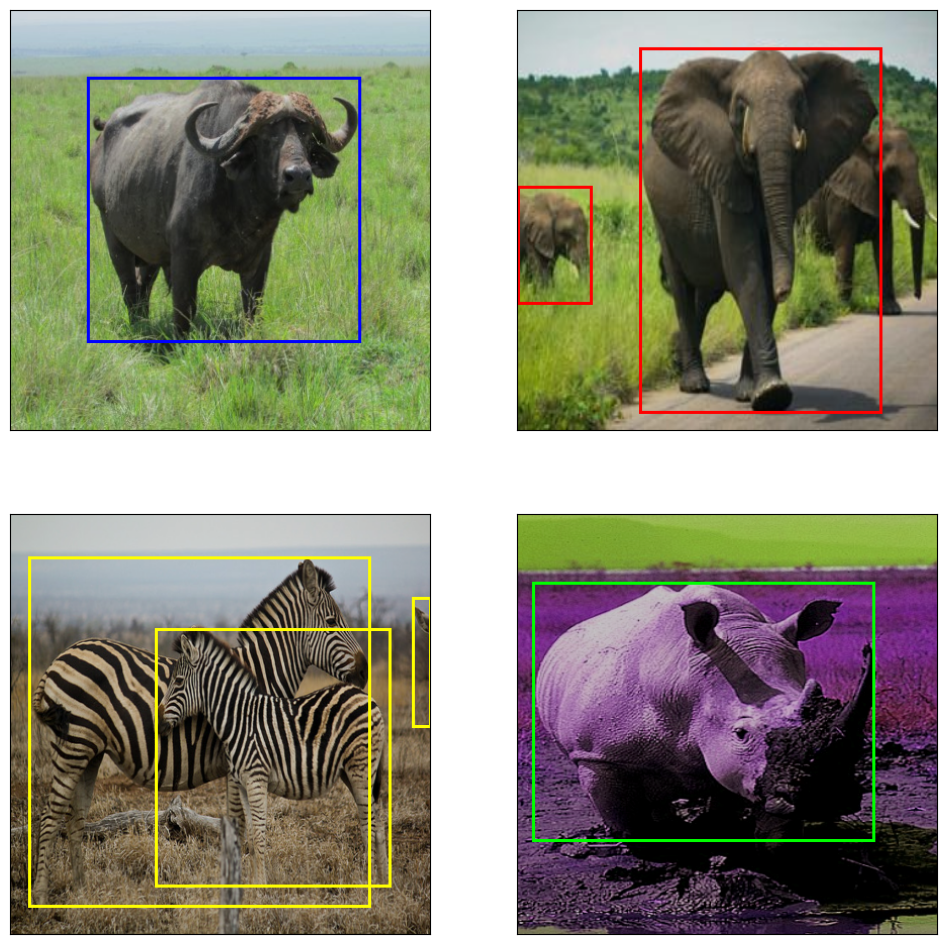

In [11]:
visualize_bb([data._make_sample(30), data._make_sample(500), data._make_sample(1100), data._make_sample(1200)])

## YOLOV2 Model Defination

The architectural configuration of YOLO.

In [12]:
import torch
import torch.nn as nn


# tuple -> (out_channels, kernel_size)
# M -> MaxPool, stage1 and stage2 are backbone
DARKNET_BACKBONE = {
    "stage1_conv": [
        (32, 3),
        "M",
        (64, 3),
        "M",
        (128, 3),
        (64, 1),
        (128, 1),
        "M",
        (256, 3),
        (128, 1),
        (256, 3),
        "M",
        (512, 3),
        (256, 1),
        (512, 3),
        (256, 1),
        (512, 3),
    ],
    "stage2_conv": ["M", (1024, 3), (512, 1), (1024, 3), (512, 3), (1024, 3)],
    "fcn_layer_in_channel": 3072,
    "fcn_layers": [(1024, 3), (1024, 3), (1024, 3)],
}


def make_conv_layers(arch_config, in_channels=3):
    layers = []
    in_channels = in_channels
    for value in arch_config:
        if type(value) == tuple:
            out_channels, kernel_size = value
            layers += [
                nn.Conv2d(
                    in_channels, out_channels, kernel_size, padding="same", bias=False
                ),  # not using bias as batchnorm
                nn.BatchNorm2d(value[0]),
                nn.LeakyReLU(negative_slope=0.1),
            ]

            in_channels = out_channels

        elif value == "M":
            layers += [nn.MaxPool2d(kernel_size=2)]

    return nn.Sequential(*layers)


# tuple -> (out_channels, kernel_size)
# M -> MaxPool
DARKNET_BACKBONE = {
    "stage1_conv": [
        (32, 3),
        "M",
        (64, 3),
        "M",
        (128, 3),
        (64, 1),
        (128, 1),
        "M",
        (256, 3),
        (128, 1),
        (256, 3),
        "M",
        (512, 3),
        (256, 1),
        (512, 3),
        (256, 1),
        (512, 3),
    ],
    "stage2_conv": ["M", (1024, 3), (512, 1), (1024, 3), (512, 3), (1024, 3)],
    "fcn_layer_in_channel": 3072,
    "fcn_layers": [(1024, 3), (1024, 3), (1024, 3)],
}



class YOLOv2(nn.Module):
    def __init__(
        self, backbone_config=DARKNET_BACKBONE, no_of_classes=C, no_of_anchor_box=N
    ):
        super().__init__()
        self.in_channels = 3
        self.arch_config = backbone_config
        self.no_of_anchor_box = no_of_anchor_box
        self.no_of_classes = no_of_classes
        self.output_layer_in_channels = self.arch_config["fcn_layers"][-1][0]

        # no of anchor boxes * (4 bb + 4 class prob + object confidence score)*13*13 for dataset with 4 classes
        self.output_channels = self.no_of_anchor_box * (self.no_of_classes + 1 + 4)

        # Conv Layers
        self.stage1_conv_layers = make_conv_layers(self.arch_config["stage1_conv"])
        self.stage2_conv_layers = make_conv_layers(
            self.arch_config["stage2_conv"],
            in_channels=self.arch_config["stage1_conv"][-1][0],
        )
        self.fcn_layers = make_conv_layers(
            self.arch_config["fcn_layers"],
            in_channels=self.arch_config["fcn_layer_in_channel"],
        )

        self.ouput_layer = nn.Conv2d(
            in_channels=self.output_layer_in_channels,
            out_channels=self.output_channels,
            kernel_size=1,
            padding="same",
        )

    def forward(self, x):
        x1 = self.stage1_conv_layers(x)
        x2 = self.stage2_conv_layers(x1)

        # Skip connection from stage 1: slice into 4 parts and concatenate
        _, _, height, width = x1.size()

        part1 = x1[:, :, : height // 2, : width // 2]
        part2 = x1[:, :, : height // 2, width // 2 :]
        part3 = x1[:, :, height // 2 :, : width // 2]
        part4 = x1[:, :, height // 2 :, width // 2 :]
        residual = torch.cat((part1, part2, part3, part4), dim=1)

        # Concatenate residual with x2
        x_concat = torch.cat((x2, residual), dim=1)

        # Pass through FCN layers
        x3 = self.fcn_layers(x_concat)

        # Pass through classifier
        
        out = self.ouput_layer(x3)
        
        #reshaping the ouput to have a ouput  for every anchor box at the end so it will be easy to acess) #B,S,S,5,9
        new_out = out.permute(0,2,3,1).contiguous()
        
        return new_out.view(new_out.size(0),new_out.size(1),new_out.size(2), self.no_of_anchor_box, 5+self.no_of_classes)


## Custom Loss Function

This is the custom loss funtion implementation. We use there loss functions CrossEntropyLoss, MSELoss, BCEWithLogitsLoss for different parts of the loss. I have modified this loss function slightly.
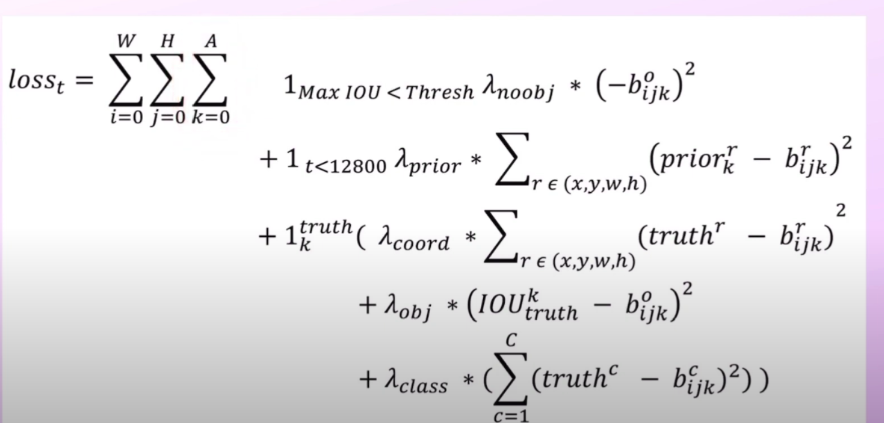

In [13]:
import torch
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss


class YoloV2_Loss(torch.nn.Module):
    """
    YOLOv2 Loss Function

    This class implements the loss function for the YOLOv2 object detection model.
    It includes components for objectness, bounding box regression, and class probabilities.

    Attributes:
        lambda_no_obj (torch.Tensor): Weight for no-object loss.
        lambda_obj (torch.Tensor): Weight for object loss.
        lambda_class (torch.Tensor): Weight for class probability loss.
        lambda_bb_cord (torch.Tensor): Weight for bounding box coordinate loss.
        C (int): Number of classes.
        binary_loss (torch.nn.Module): Binary cross-entropy loss with logits.
        logistic_loss (torch.nn.Module): Cross-entropy loss for class probabilities.
        regression_loss (torch.nn.Module): Mean squared error loss for bounding box regression.
    """

    def __init__(self, C=C, device=DEVICE):
        """
        Initializes the YOLOv2 loss function.

        Args:
            C (int, optional): Number of classes. Defaults to 4.
            device (str, optional): Device to place the tensors on. Defaults to 'cpu'.
        """
        super(YoloV2_Loss, self).__init__()
        self.lambda_no_obj = torch.tensor(1.3, device=device)
        self.lambda_obj = torch.tensor(1.0, device=device)
        self.lambda_class = torch.tensor(1.0, device=device)
        self.lambda_bb_cord = torch.tensor(6.0, device=device)
        self.C = C

        # Loss functions
        self.binary_loss = BCEWithLogitsLoss()  # Binary cross-entropy with logits

        self.logistic_loss = (
            CrossEntropyLoss()
        )  # Cross-entropy loss for class probabilities

        self.regression_loss = (
            MSELoss()
        )  # Mean squared error loss for bounding box regression

    def forward(self, pred, ground_truth):
        """
        Computes the YOLOv2 loss.

        Args:
            pred (torch.Tensor): Predictions from the model. Shape (B, S, S, A*(5+C)).
            ground_truth (torch.Tensor): Ground truth labels. Shape (B, S, S, A*(5+C)).

        Returns:
            torch.Tensor: Total loss.
        """
        # Identify object and no-object cells
        obj = ground_truth[..., 0] == 1
        no_obj = ground_truth[..., 0] == 0

        # No-object loss
        no_obj_loss = self.binary_loss(
            pred[no_obj][..., 0], ground_truth[no_obj][..., 0]
        )

        # Object loss
        obj_loss = self.binary_loss(pred[obj][..., 0], ground_truth[obj][..., 0])

        # Bounding box regression loss
        # Predicted bounding box coordinates: sigmoid for x, y and exp for w, h
        pred_bb = torch.cat(
            (torch.sigmoid(pred[obj][..., 1:3]), torch.exp(pred[obj][..., 3:5])), dim=-1
        )
        
        gt_bb = ground_truth[obj][..., 1:5]
        bb_cord_loss = self.regression_loss(pred_bb, gt_bb)

        # Class probability loss
        pred_prob = pred[obj][..., 5:]

        class_loss = self.logistic_loss(
            pred_prob, ground_truth[obj][..., 5:]
        )  # the classes are one-hot encoded so no .long()

        # Total loss calculation with weighted components
        total_loss = (
            self.lambda_bb_cord * bb_cord_loss
            + self.lambda_no_obj * no_obj_loss
            + self.lambda_obj * obj_loss
            + self.lambda_class * class_loss
        )

        return total_loss


#### Testing the loss function 

In [14]:
g = torch.Generator().manual_seed(0)

pred = torch.randn((32, 13,13,5,9),generator=g)
ground_truth = torch.randn((32, 13,13,5,9),generator=g)
ground_truth[..., 0] = torch.empty_like(ground_truth[..., 0], dtype=torch.long).random_(2)
ground_truth[...,5:] = torch.empty_like(ground_truth[..., 5:], dtype=torch.long).random_(2)
loss = YoloV2_Loss()
print(loss(pred, ground_truth))

tensor(42.8028, device='cuda:0')


## Weight Transfer and YOLO Training

Let's test if the loss function is working properly on an image

In [15]:
model = YOLOv2()

In [16]:
img, target = data[0]
target = target.unsqueeze(dim=0)
pred = model(img.unsqueeze_(dim=0))
loss(pred, target)

tensor(5.2910, device='cuda:0', grad_fn=<AddBackward0>)

### Loading weights from Backbone Network

I have already trained the backbone network (Darknet-19), we will now transfer the weights from Darknet-19 as backbone to our YOLOV2 network. In the network defination, In YOLO stage1 and stage 2 are part backbone network.

Link: https://www.kaggle.com/models/amitpant7/darknet-19

In [18]:

def transfer_wts(model):
    """
    Transfers weights from a pre-trained Darknet19 model to the YOLO model.

    This function loads the pre-trained weights from a specified file and transfers
    them to the YOLO model. It matches the weights layer-by-layer for those layers
    that start with 'stage'.

    Args:
        model (torch.nn.Module): The YOLO model to which weights are transferred.

    Returns:
        torch.nn.Module: The YOLO model with transferred weights.

    Note:
        The function assumes that the pre-trained weights are stored in a file
        named 'darknet_19_state.pt' located in the './models/' directory.
    """
    # Load pre-trained weights from Darknet19 model
    darknet19_wts = torch.load('/kaggle/input/darknet-19/pytorch/statedict/1/darknet_19_state.pt')
    yolo_state = model.state_dict()
    
    match_keys = []

    # Match keys that start with 'stage'
    for key in yolo_state.keys():
        if key.startswith('stage'):
            match_keys.append(key)

    print('Total Layers Matched:', len(match_keys) // 6)

    # Verify before weight transfer
    print('To Verify, Before:', yolo_state[match_keys[0]].sum())
    
    with torch.no_grad():
        for des_key, src_key in zip(match_keys, darknet19_wts.keys()):
            if yolo_state[des_key].shape == darknet19_wts[src_key].shape:
                yolo_state[des_key] = darknet19_wts[src_key]
            else:
                print('Weight Transfer Failed')
                break

    # Verify after weight transfer
    print('To Verify, After:', yolo_state[match_keys[0]].sum())
    
    model.load_state_dict(yolo_state)
    print('Weight transfer complete')
    
    return model

model = transfer_wts(model)

Total Layers Matched: 18.0
To Verify, Before: tensor(2.7200)


#### Another weight transfer check
We can also check the weight transfer by calculating the loss again on the same image as that was data[0].

In [20]:
pred = model(img)
loss(pred, target)

tensor(4.7266, device='cuda:0', grad_fn=<AddBackward0>)

The loss is different so the weight transfer is sucesfull. Also this verifies the proper working of loss function.

## Some Useful Utilities Related to Training, Postprocessing and Evaluation

### Simple way to track progress of Model
This will check the model correct prediction for object, no object and class.

In [21]:
def check_model_accuracy(preds, targets ,thres = 0.5 ):
    total_class, class_corr = 0,0
    total_obj, obj_corr = 0,0
    total_no_obj, no_obj_corr = 0, 0
    sig = torch.nn.Sigmoid()
    
    # No object score will be the recall value
 
    # Class Score will be the recall 
    
    obj = targets[..., 0] == 1   #mask
    no_obj = targets[..., 0] == 0 
    
    preds[..., 0] = sig(preds[..., 0])
    
    
    class_corr = torch.sum((torch.argmax(preds[obj][..., 5:], dim=-1) == torch.argmax(targets[obj][...,5:],dim=-1)))

    total_class = torch.sum(obj)
    
    
    
    obj_corr = torch.sum(preds[obj][..., 0]>thres)
    total_obj = torch.sum(obj)+ 1e-6   # to avoid divide by zero
    
    no_obj_corr = torch.sum(preds[no_obj][..., 0]<thres)
   
    total_no_obj = torch.sum(no_obj)
    
  
    return torch.tensor([total_class, class_corr, total_obj, obj_corr, total_no_obj, no_obj_corr])

                        #     print('Class Score', (100*class_corr/total_class_pred).item())
#     print('Object Score', (100*obj_corr/total_obj_prd).item())
#     print('No object Score', (100*no_obj_corr/total_no_obj).item())
                        

def cal_epoch_acc(total_class_pred, class_corr, total_obj_prd, obj_corr, total_no_obj, no_obj_corr):
    print('Class Score (R)', 100*class_corr/total_class_pred)
    print('Object Score (R)', 100*obj_corr/total_obj_prd)
    print('No object Score (R)', 100*no_obj_corr/total_no_obj)
    

### Post Processing the Outputs to Appropriate Formats

In [22]:

def process_preds(preds, anchor_boxes= ANCHOR_BOXES, device = DEVICE):
    """Takes predictions in float and returns the pixel values as [obj_score, center_cords(x,y), w, h, class_prob]

    Args:
        preds (_type_): shape[B, S, S, N, C+5]
        anchor_boxes (anchor_boxes, optional): _description_. Defaults to ANCHOR_BOXES.
        thre (float, optional): Thershold value to consider prediction as object. Defaults to 0.5.

    Returns:
        tensor: New preds with [conf_score, bbcordi, classes]
    """

    
    # Calculating the center coordinates of predicted bounding box.
    sig = torch.nn.Sigmoid()
    preds[..., 0:1] = sig(preds[..., 0:1] )   #objectness score.
    preds[..., 1:3] = sig(preds[..., 1:3])  # sig(tx) in paper, back to pixesl from float
   
    #for getting the center point of pred bb, bx = sig(tx)+cx in paper
    
    cx = cy = torch.tensor([i for i in range(S)], device=device)
    preds = preds.permute((0,3,4, 2,1))    #permute to obtain the shape (B,5,9, 13,13) so that 13,13 can be updated
    
    preds[...,1:2,:,:] += cx
    preds = preds.permute(0,1,2,4,3)
    preds[...,2:3,:,:] += cy                             
    preds = preds.permute((0,3,4, 1,2))   #bakck to B,13,13,5,9
    
    preds[..., 1:3]*=32  #to pixels
    
    #Calculating the height and width in pixels
    
        # Calculating the height and widht 
    preds[..., 3:5] = torch.exp(preds[..., 3:5])    #pw*e^tw in paper
    # anchor_matrix = torch.empty_like(preds)
    preds[...,3:5]*=torch.tensor(anchor_boxes, device=device)  
    # preds+=anchor_matrix
    preds[..., 3:5] = preds[..., 3:5]*32  # back to pixel values
    
    
    return preds

### Non Max Supression

In [23]:
import torchvision


def non_max_suppression(boxes, scores, io_threshold = 0.4):
    """
    Perform non-maximum suppression to eliminate redundant bounding boxes based on their scores.

    Args:
        boxes (Tensor): Tensor of shape (N, 4) containing bounding boxes in the format (x_center, y_center, width, height).
        scores (Tensor): Tensor of shape (N,) containing confidence scores for each bounding box.
        threshold (float): Threshold value for suppressing overlapping boxes.

    Returns:
        Tensor: Indices of the selected bounding boxes after NMS.
    """
    # Convert bounding boxes to [x_min, y_min, x_max, y_max] format
    boxes = convert_to_corners(boxes)
#     print(boxes)

    # Apply torchvision.ops.nms
    keep = torchvision.ops.nms(boxes, scores, io_threshold)

    return keep


### Mean Average Precision(mAP) 

In [24]:
!pip install torcheval
from torchvision import ops
from torcheval.metrics import AUC

#depends on non_max_supression_implementation and post_processing 
# iou_thres_for_corr_predn-.
def mean_average_precision(predictions, targets, data, iou_thres_nms = 0.4, iou_thres_for_corr_predn =0.4, C=C):
    """Calculates Mean avg precision for a single batch, to calculate for all batch collect prediction 
    and targets in a tensor and pass it here

    Args:
        predictions (_type_): Model outputs in the tensor format (B, S,S,N,C+5)
        targets (_type_): _description_
        data (_type_): Custom Dataset instance
        iou_thres_nms (float, optional): Threshold for IOU in non max supression. Defaults to 0.4.
        iou_thres_for_corr_predn (float, optional):  Min iou with ground bb to consider it as correct prediction. Defaults to 0.4.

    """
    
    
    ep = 1e-6
    #getting back pixel values:
    processed_preds = process_preds(predictions).clone()
    pr_matrix = torch.empty(9,C, 2)   #Precision and recall values at 9 different levels of threh(confidance score)

    for thres in range(1, 10, 1):
        
        ground_truth = targets.clone()
        
        conf_thres = thres/10
        
        local_pr_matrix = torch.zeros(C, 3)  #Corr_pred, total_preds, ground_truth for every class 
        
        
        for i in range(processed_preds.size(0)):  #looping over all preds

            #processing the preds to make it suitable 
            preds = processed_preds[i]
            obj = preds[...,0] > conf_thres

            bboxes = torch.flatten(preds[obj][...,1:5], end_dim = -2)
            scores = torch.flatten(preds[obj][...,0])
            _, ind = torch.max(preds[obj][..., 5:],dim = -1)
            classes = torch.flatten(ind)


            best_boxes = non_max_suppression(bboxes, scores, iou_thres_nms)



            filtered_bbox = bboxes[best_boxes]
            filtered_classes = classes[best_boxes]
            

    #         print(filtered_bbox[filtered_classes==0])
            gt_bboxes, labels = data.inverse_target(ground_truth[i].unsqueeze(0))  #inverse_target expects batched
    #         print(gt_bboxes, labels)
            #matche the one bbox among the predicted boxes with the ground thruth box that gives higesht iou.
            tracker = torch.zeros_like(labels)   # to keep track of matched boxes
             
            for c in range(C):
                total_preds = torch.sum(filtered_classes==c)
                corr_preds = 0
                actual_count = torch.sum(labels==c)
                for box in filtered_bbox[filtered_classes==c]:
                    best_iou = 0
                    for index, value in enumerate(labels) :
                        if c == value:

                            iou = intersection_over_union(box, gt_bboxes[index])  #format is cx,cy, w,h

                            if iou > best_iou and tracker[index]==0:
                                best_iou = iou
                                temp = index
#                             
                    if best_iou > iou_thres_for_corr_predn:
                        tracker[temp] = 1
                        corr_preds+=1


                local_pr_matrix[c] += torch.tensor([corr_preds, total_preds, actual_count])
            
            precision , recall = local_pr_matrix[:,0]/(local_pr_matrix[:,1]+ep), local_pr_matrix[:,0]/(local_pr_matrix[:,2]+ep)  #pr at a certain threshold c
#             print(precision, recall) # should be of shape C
            
            pr_matrix[thres-1] = torch.cat((precision.view(-1,1), recall.view(-1,1)), dim=1) 
        
    
    
    # precision_list = torch.nan_to_num(torch.tensor(precision_list), nan = 0)
    pr_matrix = pr_matrix.permute(1,0,2)  #now shape class, all pr values


    #lets calculate the mean precision 
    metric = AUC(n_tasks=C)
    metric.update(pr_matrix[...,0], pr_matrix[...,1])
    average_precision = metric.compute()
    average_precision = metric.compute()

    return average_precision.mean()                   
                        

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.8 MB/s eta 0:00:00


## Training the YOLOv2 Model

In [29]:
import time
from tqdm.auto import tqdm
import shutil
import math

def train_model(model, criterion, optimizer, scheduler, dataloaders=dataloaders, dataset_sizes=dataset_sizes, batch_size=BATCH_SIZE, num_epochs=5, device=DEVICE):
    """
    Train the model and evaluate its performance.

    Args:
        model (torch.nn.Module): The model to train.
        criterion (callable): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        scheduler (torch.optim.lr_scheduler): The learning rate scheduler.
        dataloaders (dict): Dictionary containing 'train' and 'val' dataloaders.
        dataset_sizes (dict): Dictionary containing sizes of 'train' and 'val' datasets.
        batch_size (int, optional): The batch size. Defaults to BATCH_SIZE.
        num_epochs (int, optional): Number of epochs to train. Defaults to 5.
        device (torch.device, optional): The device to use for training. Defaults to DEVICE.

    Returns:
        torch.nn.Module: The trained model with the best validation mAP.
    """
    since = time.time()
    best_map = 0

    tempdir = 'models/temp'
    os.makedirs(tempdir, exist_ok=True)
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                no_of_batches = math.ceil(dataset_sizes[phase] / batch_size)
                all_preds = torch.zeros((no_of_batches, batch_size, S, S, N, C + 5))
                all_targets = torch.zeros((no_of_batches, batch_size, S, S, N, C + 5))

            running_loss = 0.0
            i = 0  # Initialize batch index for 'val' phase

            for inputs, targets in tqdm(dataloaders[phase], leave=False):
                inputs = inputs.to(device)
                targets = targets.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else:
                        # For mAP calculation
                        try:
                            all_preds[i] = outputs.detach().cpu()
                            all_targets[i] = targets.detach().cpu()
                        except:
                            pass
                        i += 1

                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f}')

            if phase == 'val':
                all_preds = all_preds.view(-1, S, S, N, C+5)
                all_targets = all_targets.view(-1, S, S, N, C+5)
                mAP = mean_average_precision(all_preds.to(device), all_targets)
                print('Mean Average Precision:', mAP.item())

                if mAP > best_map:
                    best_map = mAP
                    torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print('Model with Best mAP:', best_map)
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    model.load_state_dict(torch.load(best_model_params_path))
    return model


In [30]:
print(f'Training \n')

torch.cuda.empty_cache()

#retraining from last checkpoint 
model = torch.load('/kaggle/working/yolo_100_epo.pth')

model = model.to(device)
criterion = YoloV2_Loss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=35, gamma=0.5)


Training 



In [31]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                   num_epochs=50)

Epoch 1/10
----------


  0%|          | 0/169 [00:00<?, ?it/s]

train Loss: 2.3312


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 2.1149
Mean Average Precision :  0.1478983461856842

Epoch 2/10
----------


  0%|          | 0/169 [00:00<?, ?it/s]

train Loss: 2.4038


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 2.0533
Mean Average Precision :  0.37205588817596436

Epoch 3/10
----------


  0%|          | 0/169 [00:00<?, ?it/s]

train Loss: 2.3162


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 2.0263
Mean Average Precision :  0.2388591319322586

Epoch 4/10
----------


  0%|          | 0/169 [00:00<?, ?it/s]

train Loss: 2.2398


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 1.9648
Mean Average Precision :  0.2869182229042053

Epoch 5/10
----------


  0%|          | 0/169 [00:00<?, ?it/s]

train Loss: 2.2613


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 2.1640
Mean Average Precision :  0.30111101269721985

Epoch 6/10
----------


  0%|          | 0/169 [00:00<?, ?it/s]

train Loss: 2.2536


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 1.9152
Mean Average Precision :  0.2246149331331253

Epoch 7/10
----------


  0%|          | 0/169 [00:00<?, ?it/s]

train Loss: 2.2730


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 2.4851
Mean Average Precision :  0.153389573097229

Epoch 8/10
----------


  0%|          | 0/169 [00:00<?, ?it/s]

train Loss: 2.1206


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 2.1230
Mean Average Precision :  0.29963475465774536

Epoch 9/10
----------


  0%|          | 0/169 [00:00<?, ?it/s]

train Loss: 2.2221


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 2.1641
Mean Average Precision :  0.18766246736049652

Epoch 10/10
----------


  0%|          | 0/169 [00:00<?, ?it/s]

train Loss: 2.0930


  0%|          | 0/19 [00:00<?, ?it/s]

val Loss: 2.0249
Mean Average Precision :  0.07456893473863602

Mode with Best mAP:  tensor(0.0746)
Training complete in 8m 50s


In [33]:
torch.save(model, 'best_map_yolo.pth')

## Visulizing the outputs

In [40]:

def visualize_outputs(
    indices, model, dataset, device=DEVICE, thres=0.9, iou_threshold=0.5
):
    """
    Visualizes the output predictions of the model on a set of images from the dataset.

    Args:
        indices (list of int): List of indices of the images to visualize.
        model (torch.nn.Module): The trained model to use for predictions.
        dataset (torch.utils.data.Dataset): The dataset containing the images and targets.
        device (torch.device): The device (CPU or GPU) to perform computations on.
        thres (float, optional): The threshold for objectness score to filter predictions. Defaults to 0.9.

    Returns:
        None
    """
    images_with_bb = []

    for index in indices:
        # Load the image and target from the dataset
        image, target = dataset[index]
        image = image.to(device)
        model = model.to(device)

        # Set the model to evaluation mode
        model.eval()

        # Get predictions from the model
        preds = model(image.unsqueeze(0))

        # Process the predictions
        preds = process_preds(preds)

        # Filter predictions based on the threshold
        obj = preds[..., 0] > thres

        bboxes = preds[obj][..., 1:5]
        scores = torch.flatten(preds[obj][..., 0])
        _, ind = torch.max(preds[obj][..., 5:], dim=-1)
        classes = torch.flatten(ind)

        # Apply non-max suppression to get the best bounding boxes
        best_boxes = non_max_suppression(bboxes, scores, io_threshold=iou_threshold)

        filtered_bbox = bboxes[best_boxes]
        filtered_classes = classes[best_boxes]

        if filtered_classes.size(0) > 0:
            sample = {
                "image": image.detach().cpu(),
                "bbox": filtered_bbox.detach().cpu(),
                "labels": filtered_classes.detach().cpu(),
            }

            images_with_bb.append(sample)

    # Visualize the bounding boxes on the images
    visualize_bb(
        images_with_bb
    )  # Blue->Buffalo, Red--> Elephant, Green--> Rhino, Yellow--> Zebra


torch.Size([0]) tensor(0, device='cuda:0')
torch.Size([0, 4]) torch.Size([0])
torch.Size([1]) tensor(1, device='cuda:0')
torch.Size([1, 4]) torch.Size([1])
torch.Size([0]) tensor(0, device='cuda:0')
torch.Size([0, 4]) torch.Size([0])
torch.Size([12]) tensor(12, device='cuda:0')
torch.Size([1, 4]) torch.Size([1])


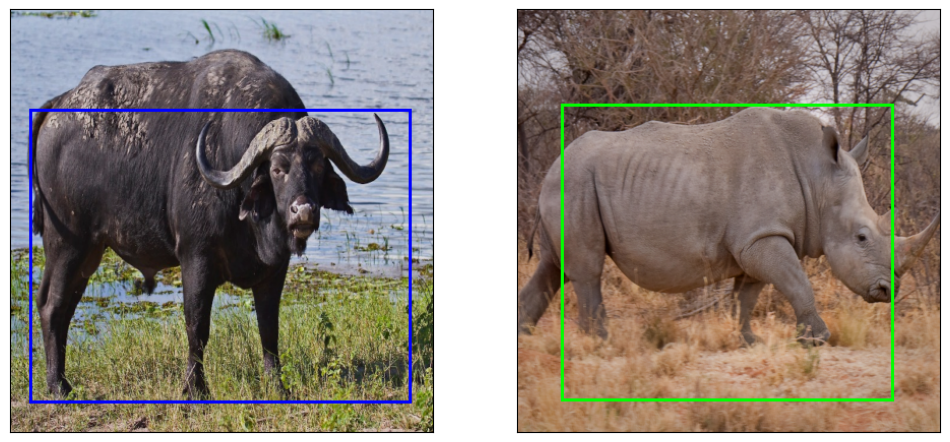

In [45]:
# model = torch.load('')
indices = np.random.randint(0, 100, size=4)
visualize_outputs(indices, model, test_data)

Lets try some sample images from the from the internet.

In [54]:
# URL of the image
url = "https://www.shutterstock.com/image-photo/asia-elephant-thailand-elephants-chiang-260nw-2154025499.jpg"

from urllib.request import urlopen
from PIL import Image

img = Image.open(urlopen(url))


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
newt = torchvision.transforms.Compose([
    v2.Resize((416,416)),  # Random resized crop to 224x224
#     transforms.RandomHorizontalFlip(),  # Random horizontal flip
    v2.ToTensor(),  # Convert PIL Image to tensor
    v2.Normalize(mean, std)  # Normalize using ImageNet mean and std
])

img = newt(img)
img = img

In [56]:
# visualize_outputs([0,1], model, [(img,0), (img,0)])

## Model Evaluation and Metric Calculations

### Mean Average Precision Calculations

Let's first calculate all the predictions and store them along with labels

In [59]:

def evaluate_model(model, dataloaders=dataloaders, dataset_sizes=dataset_sizes, batch_size=BATCH_SIZE, device=DEVICE, phase = 'val'):
    """
    Evaluates a PyTorch model on the validation dataset.

    Args:
    - model (torch.nn.Module): The PyTorch model to be evaluated.
    - dataloaders (dict): A dictionary containing dataloaders for different phases (e.g., 'train', 'val').
    - dataset_sizes (dict): A dictionary containing the sizes of datasets for different phases.
    - batch_size (int): The batch size for evaluation.
    - device (torch.device): The device (e.g., 'cuda' or 'cpu') on which to perform evaluation.

    Returns:
    - all_preds (torch.Tensor): Predictions made by the model, reshaped for evaluation.
    - all_targets (torch.Tensor): Ground truth labels, reshaped for evaluation.
    """

    model = model.to(device)
    model.eval()
    no_of_batches = math.ceil(dataset_sizes[phase] / batch_size)
    all_preds = torch.empty((no_of_batches, batch_size, S, S, N, C+5))
    all_targets = torch.empty((no_of_batches, batch_size, S, S, N , C+5))

    for i, (image, target) in enumerate(dataloaders[phase]):
        image = image.to(device)
        preds = model(image)

        # if the last batch doesn't have enough images, it will throw error while updating tensor.
        try:
            all_preds[i] = preds.detach().to('cpu')
            all_targets[i] = target.detach().to('cpu')
        except:
            print('Last batch has shape', preds.shape)

    all_preds = all_preds.view(-1, S, S, N, C+5)
    all_targets = all_targets.view((-1, S, S, N, C+5))

    
    map = mean_average_precision(all_preds.to(device), all_targets)
    print('The mean average precision on {phase}:', map.item() )
    return map


torch.Size([6, 13, 13, 5, 9])
Last batch has shape None


(torch.Size([152, 13, 13, 5, 9]), torch.Size([152, 13, 13, 5, 9]))

In [60]:
map = evaluate_model(model)

tensor(0.2584)

This is the end of notebook thanks for reading.